# Intelligent Agents: Reflex-Based Agents for the Vacuum-cleaner World

Student Name: Blake Gebhardt

## Instructions

Total Points: Undergrads 100 / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the completely rendered notebook as a PDF file. 

## Introduction

In this assignment you will implement a simulator environment for an automatic vacuum cleaner robot, a set of different reflex-based agent programs, and perform a comparison study for cleaning a single room. Focus on the __cleaning phase__ which starts when the robot is activated and ends when the last dirty square in the room has been cleaned. Someone else will take care of the agent program needed to navigate back to the charging station after the room is clean.

## PEAS description of the cleaning phase

__Performance Measure:__ Each action costs 1 energy unit. The performance is measured as the sum of the energy units used to clean the whole room.

__Environment:__ A room with $n \times n$ squares where $n = 5$. Dirt is randomly placed on each square with probability $p = 0.2$. For simplicity, you can assume that the agent knows the size and the layout of the room (i.e., it knows $n$). To start, the agent is placed on a random square.

__Actuators:__ The agent can clean the current square (action `suck`) or move to an adjacent square by going `north`, `east`, `south`, or `west`.

__Sensors:__ Four bumper sensors, one for north, east, south, and west; a dirt sensor reporting dirt in the current square.  


## The agent program for a simple randomized agent

The agent program is a function that gets sensor information (the current percepts) as the arguments. The arguments are:

* A dictionary with boolean entries for the for bumper sensors `north`, `east`, `west`, `south`. E.g., if the agent is on the north-west corner, `bumpers` will be `{"north" : True, "east" : False, "south" : False, "west" : True}`.
* The dirt sensor produces a boolean.

The agent returns the chosen action as a string.

Here is an example implementation for the agent program of a simple randomized agent:  

In [37]:
import numpy as np

actions = ["north", "east", "west", "south", "suck"]

def simple_randomized_agent(bumpers, dirty):
    return np.random.choice(actions)

In [38]:
# define percepts (current location is NW corner and it is dirty)
bumpers = {"north" : True, "east" : False, "south" : False, "west" : True}
dirty = True

# call agent program function with percepts and it returns an action
simple_randomized_agent(bumpers, dirty)

'south'

__Note:__ This is not a rational intelligent agent. It ignores its sensors and may bump into a wall repeatedly or not clean a dirty square. You will be asked to implement rational agents below.

## Simple environment example

We implement a simple simulation environment that supplies the agent with its percepts.
The simple environment is infinite in size (bumpers are always `False`) and every square is always dirty, even if the agent cleans it. The environment function returns a performance measure which is here the number of cleaned squares (since the room is infinite and all squares are constantly dirty, the agent can never clean the whole room as required in the PEAS description above). The energy budget of the agent is specified as `max_steps`. 

In [39]:
def simple_environment(agent, max_steps, verbose = True):
    num_cleaned = 0
    
    for i in range(max_steps):
        dirty = True
        bumpers = {"north" : False, "south" : False, "west" : False, "east" : False}

        action = agent(bumpers, dirty)
        if (verbose): print("step", i , "- action:", action) 
        
        if (action == "suck"): 
            num_cleaned = num_cleaned + 1
        
    return num_cleaned
        


Do one simulation run with a simple randomized agent that has enough energy for 20 steps.

In [40]:
simple_environment(simple_randomized_agent, max_steps = 20)

step 0 - action: south
step 1 - action: south
step 2 - action: suck
step 3 - action: west
step 4 - action: south
step 5 - action: east
step 6 - action: suck
step 7 - action: west
step 8 - action: south
step 9 - action: south
step 10 - action: north
step 11 - action: south
step 12 - action: suck
step 13 - action: suck
step 14 - action: suck
step 15 - action: south
step 16 - action: north
step 17 - action: south
step 18 - action: south
step 19 - action: suck


6

# Tasks

## General [10 Points]

1. Make sure that you use the latest version of this notebook. Sync your forked repository and pull the latest revision. 
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement inteligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formated professionally. 
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your PDF file is readable. For example, long lines are cut off in the PDF file. You don't have control over page breaks, so do not worry about these.
4. Document your code. Add a short discussion of how your implementation works and your design choices.


## Task 1: Implement a simulation environment [20 Points]

The simple environment above is not very realistic. Your environment simulator needs to follow the PEAS description from above. It needs to:

* Initialize the environment by storing the state of each square (clean/dirty) and making some dirty. ([Help with random numbers and arrays in Python](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/random_numbers_and_arrays.ipynb))
* Keep track of the agent's position.
* Call the agent function repeatedly and provide the agent function with the sensor inputs.  
* React to the agent's actions. E.g, by removing dirt from a square or moving the agent around unless there is a wall in the way.
* Keep track of the performance measure. That is, track the agent's actions until all dirty squares are clean and count the number of actions it takes the agent to complete the task.

The easiest implementation for the environment is to hold an 2-dimensional array to represent if squares are clean or dirty and to call the agent function in a loop until all squares are clean or a predefined number of steps have been reached (i.e., the robot runs out of energy).

The simulation environment should be a function like the `simple_environment()` and needs to work with the simple randomized agent program from above. **Use the same environmnt for all your agent implementations in the tasks below.**

*Note on debugging:* Debugging is difficult. Make sure your environment prints enough information when you use `verbose = True`. Also, implementing a function that the environment can use to displays the room with dirt and the current position of the robot at every step is very useful.  

In [41]:
def print_environment(environment):
    print(np.matrix(environment))

In [42]:
# Your code and description goes here
def get_sensors(environment, botX, botY):
    dimensions = len(environment)
    sides = {"north" : False, "south" : False, "west" : False, "east" : False}
    if botY == 0:
        sides['west'] = True
    if botX == 0:
        sides['north'] = True
    if botY == dimensions-1:
        sides['east'] = True
    if botX == dimensions-1:
        sides['south'] = True
    return sides

def check_clean(environment):
    dimensions = len(environment)
    for i in range(dimensions):
        for j in range(dimensions):
            if environment[i][j] == 'dirty':
                return False
    return True


def environment(agent, steps, verbose = False, dimensions = 5):
    #if steps is -1 it should run until the room is clean rather than the steps are reached
    movements = {'north': {'x': -1, 'y': 0}, 'south': {'x': 1, 'y': 0}, 'east': {'x': 0, 'y': 1}, 'west': {'x': 0, 'y': -1}}
    env = [ ['clean']*dimensions for i in range(dimensions)]
    #assign dirt
    for i in range(dimensions):
        for j in range(dimensions):
            if np.random.rand() < .2:
                env[i][j] = 'dirty'

    #place vacuum
    botX = np.random.randint(dimensions)
    botY = np.random.randint(dimensions)
    underTheBot = env[botX][botY]
    env[botX][botY] = 'bot'

    #do all steps for bot
    if verbose:
        print('Starting Env:')
        print_environment(env)
        print()

    count = 0
    if steps == -1:
        while True:
            walls = get_sensors(env, botX, botY)
            dirt = False
            if underTheBot == 'dirty':
                dirt = True
            move = agent(walls, dirt)
            if move == 'suck':
                underTheBot = 'clean'
            else:
                if walls[move] is False:
                    env[botX][botY] = underTheBot
                    botX += movements[move]['x']
                    botY += movements[move]['y']
                    underTheBot = env[botX][botY]
                    env[botX][botY] = 'bot'
            if check_clean(env):
                if verbose:
                    print('Done in', i, 'steps')
                break
            if verbose:
                print_environment(env)
                print()
            count += 1
        return count

    for i in range(steps):
        walls = get_sensors(env, botX, botY)
        dirt = False
        if underTheBot == 'dirty':
            dirt = True
        move = agent(walls, dirt)
        if move == 'suck':
            underTheBot = 'clean'
        else:
            if walls[move] is False:
                env[botX][botY] = underTheBot
                botX += movements[move]['x']
                botY += movements[move]['y']
                underTheBot = env[botX][botY]
                env[botX][botY] = 'bot'
        if check_clean(env):
            if verbose:
                print('Done in', i, 'steps')
            break
        if verbose:
            print_environment(env)
            print()
        count += 1

    if verbose:
        print('Post steps completed: ')
        print_environment(env)
    return count, check_clean(env)


environment(simple_randomized_agent, 500)

(160, True)

In [43]:
environment(simple_randomized_agent, 500, False, 5)

(119, True)

## Task 2:  Implement a simple reflex agent [10 Points] 

The simple reflex agent randomly walks around but reacts to the bumper sensor by not bumping into the wall and to dirt with sucking. Implement the agent program as a function.

_Note:_ Agents cannot directly use variable in the environment. They only gets the percepts as the arguments to the agent function.

In [44]:
# Your code and description goes here

# Your code and description goes here
def simple_reflex_agent(bumpers, dirty):
    if dirty:
        return 'suck'
    open = []
    for key, value in bumpers.items():
        if value is False:
            open.append(key)
    return np.random.choice(open)

environment(simple_reflex_agent, 500)


(62, True)

## Task 3: Implement a model-based reflex agent [20 Points]

Model-based agents use a state to keep track of what they have done and perceived so far. Your agent needs to find out where it is located and then keep track of its current location. You also need a set of rules based on the state and the percepts to make sure that the agent will clean the whole room. For example, the agent can move to a corner to determine its location and then it can navigate through the whole room and clean dirty squares.

Describe how you define the __agent state__ and how your agent works before implementing it. ([Help with implementing state information on Python](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/store_agent_state_information.ipynb))

In [45]:
# Your short description of the state and your implementation goes here
# I first send the bot to the north-west corner and weaving up and down the environment from there.
# I have global variables that remember if weaving has started or if I am still heading to the north-west corner. 
# After that, another globabl variable tracks which direction I am currently weaving.

In [54]:
# Your code goes here
started = False
heading = 'south'
# seen_corner = False

def model_based_agent(bumpers, dirty):
    global started
    global heading
    #always clean if dirty
    if dirty:
        return 'suck'

    #navigate towards the northwest corner
    if not started and not bumpers['north']:
        return 'north'

    if not started and not bumpers['west']:
        return 'west'

    if not started and bumpers['north'] and bumpers['west']:
        started = True
        return 'south'

    #start the weaving pattern
    if bumpers[heading]:
        heading = 'north' if heading == 'south' else 'south'
        return 'east'

    else:
        return heading
environment(model_based_agent, 500)

(26, True)

## Task 4: Simulation study [30 Points]

Compare the performance (the performance measure is defined in the PEAS description above) of the agents using  environments of different size. E.g., $5 \times 5$, $10 \times 10$ and
$100 \times 100$. Use 100 random runs for each. Present the results using tables and graphs. Discuss the differences between the agents. 
([Help with charts and tables in Python](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/charts_and_tables.ipynb))

In [47]:
# Your code goes here
import matplotlib.pyplot as plt
random_five = 0
random_five_arr = []
random_ten = 0
random_ten_arr = []
random_hundred = 0
random_hundred_arr = []

reflex_five = 0
reflex_five_arr = []
reflex_ten = 0
reflex_ten_arr = []
reflex_hundred = 0
reflex_hundred_arr = []

model_five = 0
model_five_arr = []
model_ten = 0
model_ten_arr = []
model_hundred = 0
model_hundred_arr = []


In [48]:
for i in range(100):
    # Add to random totals
    tmp = environment(simple_randomized_agent, -1, False, 5)
    random_five += tmp
    random_five_arr.append(tmp)
    tmp = environment(simple_randomized_agent, -1, False, 10)
    random_ten += tmp
    random_ten_arr.append(tmp)
    tmp = environment(simple_randomized_agent, 10000, False, 100)
    random_hundred += tmp[0]
    random_hundred_arr.append(tmp)

    # Add to reflex totals
    tmp = environment(simple_reflex_agent, -1, False, 5)
    reflex_five += tmp
    reflex_five_arr.append(tmp)
    tmp = environment(simple_reflex_agent, -1, False, 10)
    reflex_ten += tmp
    reflex_ten_arr.append(tmp)
    tmp = environment(simple_reflex_agent, 10000, False, 100)
    reflex_hundred += tmp[0]
    reflex_hundred_arr.append(tmp)

    # Add to model totals
    heading = 'south'
    started = False
    tmp = environment(model_based_agent, -1, False, 5)
    model_five += tmp
    model_five_arr.append(tmp)

    heading = 'south'
    started = False
    tmp = environment(model_based_agent, -1, False, 10)
    model_ten += tmp
    model_ten_arr.append(tmp)

    heading = 'south'
    started = False
    tmp = environment(model_based_agent, -1, False, 100)
    model_hundred += tmp
    model_hundred_arr.append(tmp)


### From above:
The performance is measured as the sum of the energy units used to clean the whole room.

I'll be limiting the 100x100 to 10,000 steps for Simple Random and Simple Reflex. I have an old i5 Mac, and there's no way they'll run all the way through in a normal amount of time. The rest of the agents will work in reasonable amounts of time.

In [49]:
random_five = int(random_five/100)
random_ten = int(random_ten/100)
random_hundred = int(random_hundred/100)

print('random five:', random_five)
print('random ten:', random_ten)
print('random hundred:', random_hundred)
print()

reflex_five = int(reflex_five/100)
reflex_ten = int(reflex_ten/100)
reflex_hundred = int(reflex_hundred/100)

print('reflex five:', reflex_five)
print('reflex ten:', reflex_ten)
print('reflex hundred:', reflex_hundred)
print()

model_five = int(model_five/100)
model_ten = int(model_ten/100)
model_hundred = int(model_hundred/100)

print('model five:', model_five)
print('model ten:', model_ten)
print('model hundred:', model_hundred)
print()

def show_graph(extra = ''):
    x_pos = range(1,101)
    global random_five_arr
    global random_ten_arr
    global random_hundred_arr

    global reflex_five_arr
    global reflex_ten_arr
    global reflex_hundred_arr

    global model_five_arr
    global model_ten_arr
    global model_hundred_arr

    plt.plot(x_pos, random_five_arr, label = "Random 5x5")
    plt.plot(x_pos, random_ten_arr, label = "Random 10x10")
    if extra == 'random':
        plt.plot(x_pos, random_hundred_arr, label = "Random 100x100")

    plt.plot(x_pos, reflex_five_arr, label = "Reflex 5x5")
    plt.plot(x_pos, reflex_ten_arr, label = "Reflex 10x10")
    if extra == 'reflex':
        plt.plot(x_pos, reflex_hundred_arr, label = "Reflex 100x100")

    plt.plot(x_pos, model_five_arr, label = "Model 5x5")
    plt.plot(x_pos, model_ten_arr, label = "Model 10x10")
    if extra == 'model':
        plt.plot(x_pos, model_hundred_arr, label = "Model 100x100")

    plt.xlabel('Iteration')
    plt.ylabel('Steps Required')
    plt.title('Steps Required Per Iteration By Agent Type')

    plt.legend()
    plt.show()



random five: 309
random ten: 2435
random hundred: 10000

reflex five: 102
reflex ten: 964
reflex hundred: 10000

model five: 26
model ten: 121
model hundred: 12091



Fill out the following table with the average performance measure for 100 random runs (you may also create this table with code):

| Size     | Randomized Agent | Simple Reflex Agent | Model-based Reflex Agent |
|----------|------------------|---------------------|--------------------------|
| 5x5     | 309 | 102 | 26 |
| 10x10   | 2435| 964 | 121|
| 100x100 | 10000| 10000 |12091 |

Add charts to compare the performance of the different agents.

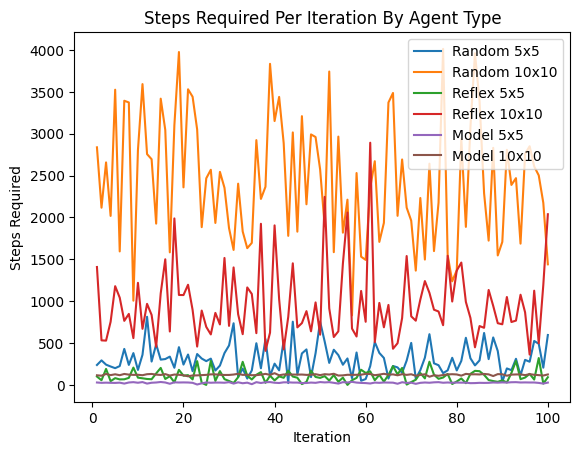

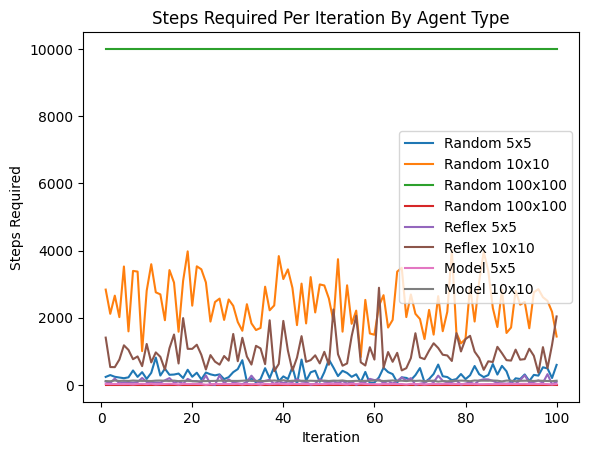

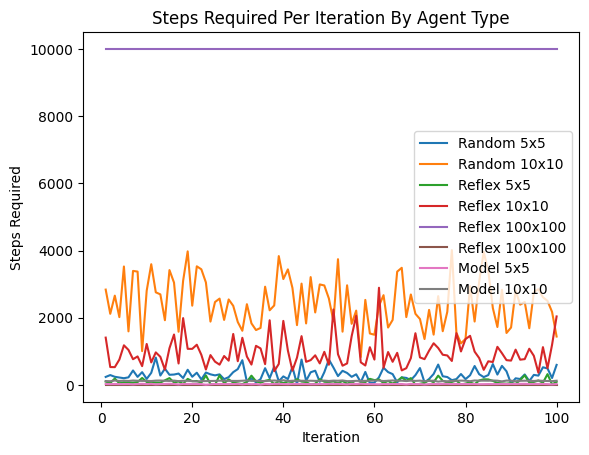

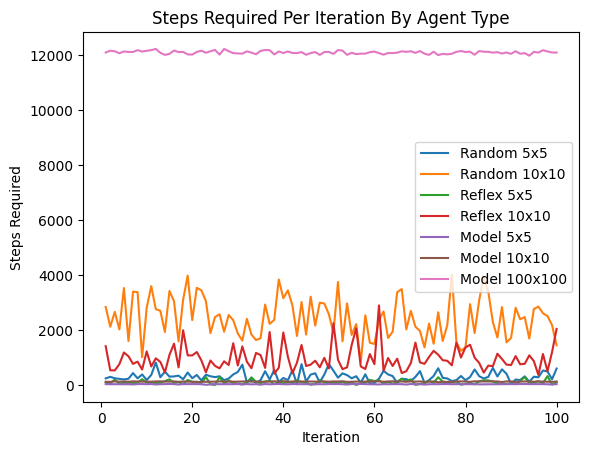

In [50]:
# Your graphs and discussion of the results goes here
show_graph()

show_graph('random')
show_graph('reflex')
show_graph('model')

## Task 5: Robustness of the agent implementations [10 Points] 

Describe how **your agent implementations** will perform 

* if it is put into a rectangular room with unknown size, 
* if the cleaning area can have an iregular shape (e.g., a hallway connecting two rooms), or 
* if the room contains obstacles (i.e., squares that it cannot pass through and trigger the bumper sensors).

## Simple Random
### Rectangular Room
    The simple random will take a very long time to clean the room. Since actions are random, the agent will revisit squares, visit dirty ones without cleaning, and probably leave a large portion of the room unvisited.
### Irregular Room
    The simple random will also take a very long time to clean the room. Random actions make accessing the irregular shape difficult. Without a systematic strategy, it might miss parts of the irregular shape. 
### Obstacles
    The simple random will, believe it or not, also take a very long time. The simple random may run into an obstacles, but since selecting an action is random, may continually bump into the obstacle. The agent will struggle to navigate around obstacles and could spend a lot of time in a small area with obstacles.

## Simple Reflex
### Rectangular Room
    The simple reflex will perform better than the simple random. Since the simple reflex can detect dirt, it will always clean a dirty square that it lands on. In the case of running into a wall, the agent will choose open directions, so every action is somewhat meaningful. However, it still uses random actions, so large rooms will take significantly longer times.
### Irregular Room
    Once again, the simple reflex will perform better than the simple random. Since it can sense when it is near a wall, our movements will always be towards a square that exists. The agent's performance is still limited by its lack of knowledge about the overall shape of the area. It won't have a systematic strategy for exploring complex shapes, and it may miss certain areas.
### Obstacles
    In a room with obstacles, the simple reflex agent will effectively respond to the presence of obstacles by avoiding them. It will randomly select open directions to move when it encounters obstacles, reducing the chances of repeatedly bumping into them.

## Model Based
### Rectangular Room
    The model-based agent will perform optimally in a rectangular room of any size. Without any obstacles, the agent will first put itself in the northwest corner and systematically weave through the room, ensuring it cleans every square. This is a great way of minimizing the necessary steps to clean the room.
### Irregular Room
    In an irregular room, the model based agent will still try to follow the weaving strategy. This will present some issues for the agent. If the irregular shape prevents it from reaching the corner or disrupts its pattern, the agent's performance will be suboptimal. It may continue its pattern in areas where cleaning is unnecessary, potentially wasting time or even becoming stuck.
### Obstacles
    If the room contains obstacles that block its access to the northwest corner or disrupt its weaving pattern, the agent may become stuck or inefficient in cleaning. The agent may repeatedly attempt to navigate around obstacles, which can result in less efficient cleaning.

## Graduate student advanced task: Obstacles [10 Points]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+5 Bonus Points].

1. Change your simulation environment tor run experiments for the following problem: Add random obstacle squares that also trigger the bumper sensor. The agent does not know where the obstacles are. Observe how this changes the performance of the three implementations.

2. Describe what would need to be done to perform better with obstacles. Add code if you can. 

In [52]:
# Your code and discussion goes here

## More advanced implementation tasks

* __Agent for and environment with obstacles:__ Implement an agent for an environment where the agent does not know how large the environment is (we assume it is rectangular), where it starts or where the obstacles are. An option would be to always move to the closest unchecked/uncleaned square (note that this is actualy depth-first search).

* __Utility-based agent:__ Change the environment for a $5 \times 5$ room, so each square has a fixed probability of getting dirty again. For the implementation, we give the environment a 2-dimensional array of probabilities. The utility of a state is defined as the number of currebntly clean squares in the room. Implement a utility-based agent that maximizes the expected utility over one full charge which lasts for 100000 time steps. To do this, the agent needs to learn the probabilities with which different squares get dirty again. This is very tricky!

In [53]:
# Your ideas/code